# Machine Learning

#### Prof. Neylson Crepalde

## Recursive Feature Selection

Curiosamente, a biblioteca `sklearn` não possui os algoritmos de *Best Subset Selection* e *Stepwise Selection* implementados. Para executá-los em Python no framework estudado, seria necessário implementarmos nós mesmos o algoritmo (o que não deve ser um problema). 

Uma implementação do *BSS* encontra-se neste link: https://stackoverflow.com/questions/22956938/exhaustively-feature-selection-in-scikit-learn

Uma implementação do *Stepwise* encontra-se neste link: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

Para fins práticos, vamos testar outro algoritmo para *feature selection* implementado no sklearn, o *Recursive Feature Selection* que trabalha de maneira muito parecido com o *Backwards Stepwise*. Para mais detalhes sobre o método, consulte a documentação: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

Vamos ao código!

### Recursive Feature Selection sem CV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [2]:
bd = pd.read_csv("https://raw.githubusercontent.com/neylsoncrepalde/ML_classes/master/Data/Hitters.csv")
bd.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
# Verificando as dimensões
bd.shape

(322, 20)

In [4]:
# Verificando os tipos
bd.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

Tem 3 variáveis dummy: **League**, **Division** e **NewLeague**. Vamos preparar os dados para o modelo.

In [5]:
# Preprocessing
bd = pd.get_dummies(bd, drop_first=True)
bd = bd.dropna()
bd.shape

(263, 20)

In [6]:
# Objetivo: predizer o Salário (Salary)
y = bd.Salary
X = bd.drop(columns="Salary")

O grande problema de usar RFS sem Cross validation é que precisamos definir de maneira arbitrária quantos features serão selecionados. Se o usuário não selecionar um número, por default, metade das features serão selecionadas.

In [7]:
# Instanciando o modelo
reg = LinearRegression()
selector = RFE(reg, n_features_to_select=10, step=1)
selector.fit(X, y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [8]:
# Quais variáveis foram selecionadas
selector.support_

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True])

In [9]:
# Variáveis selecionadas são atribuídas ao ranking 1
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  9, 10,  5,  2,  4,  3,  8,  7,  6,  1,
        1,  1])

In [10]:
# O atributo estimator_ contém a regressão linear estimada apenas com as variáveis selecionadas
selector.estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# Verificando as variáveis que foram selecionadas
varnames = X.columns[selector.ranking_ == 1]
print(varnames)

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League_N',
       'Division_W', 'NewLeague_N'],
      dtype='object')


In [12]:
# Verificando os coeficientes de cada uma
pd.DataFrame(zip(varnames, selector.estimator_.coef_), columns=["Feature", "Coef"])

,Feature,Coef
0,AtBat,-1.833559
1,Hits,8.307643
2,HmRun,3.893402
3,Runs,-1.601360
4,RBI,1.489217
5,Walks,5.415074
6,Years,31.662246
7,League_N,69.450367
8,Division_W,-117.546879
9,NewLeague_N,-14.129157


## RFS com CV

In [13]:
from sklearn.feature_selection import RFECV

In [14]:
# Instanciando o modelo
reg = LinearRegression()
selector2 = RFECV(reg, step=1, cv=5)  # define 5-fold
selector2.fit(X, y)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [15]:
# Quantos features foram selecionados por cross validation?
selector2.n_features_

12

In [16]:
# Um pouco mais do que sem cross validation. Vamos olhar para os resultados desse modelo
print(selector2.support_)
print(selector2.ranking_)

[ True  True  True  True  True  True  True False False False  True False
  True False False False  True  True  True]
[1 1 1 1 1 1 1 7 8 3 1 2 1 6 5 4 1 1 1]


In [17]:
# Verificando as variáveis que foram selecionadas
varnames = X.columns[selector2.ranking_ == 1]
print(varnames)
# Verificando os coeficientes de cada uma
pd.DataFrame(zip(varnames, selector2.estimator_.coef_), columns=["Feature", "Coef"])

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CRuns',
       'CWalks', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')


,Feature,Coef
0,AtBat,-2.050795
1,Hits,8.262864
2,HmRun,4.868262
3,Runs,-4.439209
4,RBI,1.260864
5,Walks,7.378576
6,Years,-13.091697
7,CRuns,1.279336
8,CWalks,-0.739217
9,League_N,72.757772


In [18]:
# Vamos olhar o grid de resultados
selector2.grid_scores_

array([-0.02614542,  0.08486438,  0.09724577,  0.07170599,  0.16613548,
        0.22500157,  0.31874883,  0.30317012,  0.30755301,  0.31074518,
        0.33836751,  0.35222395,  0.34593969,  0.33491426,  0.3430118 ,
        0.34813654,  0.32617189,  0.33862473,  0.34349502])

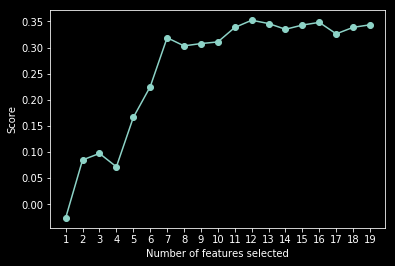

In [19]:
# Num gráfico bonitinho
plt.style.use("dark_background")
plt.plot(selector2.grid_scores_, marker="o")
plt.xticks(range(19), range(1, 20)) # muda os labels do x para começar no 1
plt.xlabel("Number of features selected")
plt.ylabel("Score")
plt.show()